# Search Algorithm : Thin Ice


In [208]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue

### Helper functions for the Maze

These are just a few helper functions for you to work with the maze/grid easily, and to visualize them in a nice way.

In [209]:
# Helper functions to work with the Maze

def printBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Simple print of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    
    print()
    for i in range(height):
        for j in range(width):
            if mazeGrid[i,j] == 1:
                print("\u25a9", end = " ")   # use some other character if the unicode does not print properly
            elif mazeGrid[i,j] == 0:
                print(".", end = " ")
        print()
        

def showBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Heatmap grid of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Blues", cbar = False)
    
    
def showBinaryMazeProblem(mazeGrid, start, goal):
    ''' Display the maze corresponding to a binary grid
        Display "start" and "goal" position on the grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinate of the "start" and "goal"
        Output : Heatmap grid of the maze with markers
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255
    
    mazeGrid[start[0], start[1]] = 128
    mazeGrid[goal[0], goal[1]] = 128
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Blues", cbar = False)

---
## Create the Maze as a 2D Grid

Let us create the maze as a standard two-dimensional grid, with reachable (blank) and unreachable (blocked) positions.

In [210]:
# Create the Maze
# 0 : empty cell, reachable within a path
# 1 : blocked cell or wall, not reachable

maze = [[1, 1, 1, 1, 1, 1, 1, 1, 1 ],
        [1, 0, 0, 0, 1, 0, 0, 0, 1 ],
        [1, 1, 1, 0, 1, 0, 0, 1, 1 ],
        [1, 1, 1, 0, 1, 0, 0, 1, 1 ],
        [1, 1, 1, 0, 0, 0, 0, 1, 1 ],
        [1, 1, 1, 1, 1, 1, 0, 1, 1 ],
        [1, 1, 0, 0, 0, 0, 0, 1, 1 ],
        [1, 0, 0, 1, 1, 1, 1, 1, 1 ],
        [1, 0, 0, 0, 0, 0, 0, 0, 1 ],
        [1, 1, 1, 1, 1, 1, 1, 1, 1 ]]


# Convert to a NumPy array
maze = np.array(maze)

# Print the maze using helper functions
print("Maze of dimensions", maze.shape)
printBinaryMaze(maze)

Maze of dimensions (10, 9)

▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ 
▩ . . . ▩ . . . ▩ 
▩ ▩ ▩ . ▩ . . ▩ ▩ 
▩ ▩ ▩ . ▩ . . ▩ ▩ 
▩ ▩ ▩ . . . . ▩ ▩ 
▩ ▩ ▩ ▩ ▩ ▩ . ▩ ▩ 
▩ ▩ . . . . . ▩ ▩ 
▩ . . ▩ ▩ ▩ ▩ ▩ ▩ 
▩ . . . . . . . ▩ 
▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ ▩ 


Display the maze as a Seaborn grayscale heatmap to clearly visualize the pattern and identify the underlying coordinates.

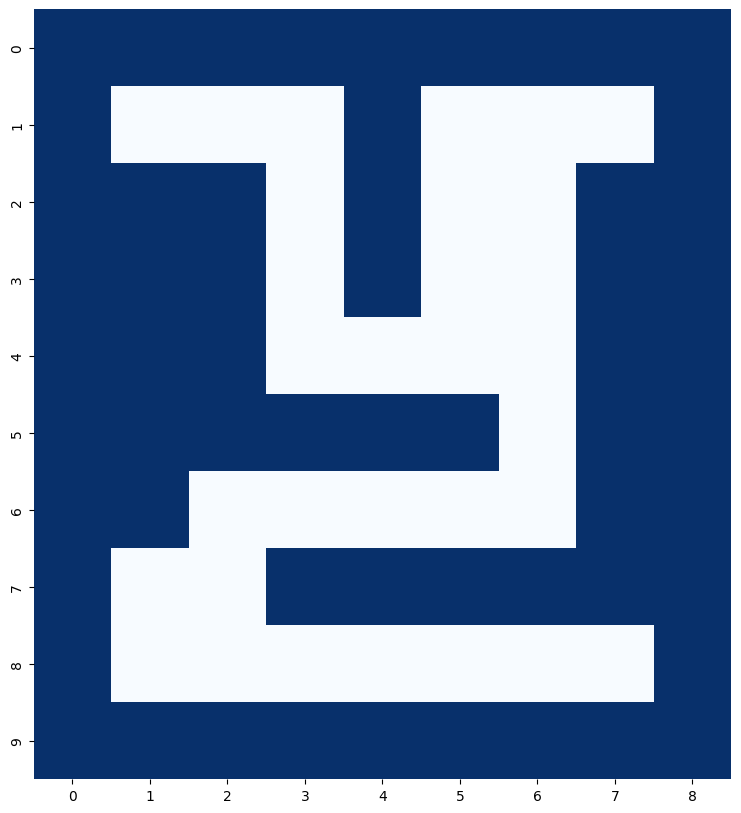

In [211]:
# Show the maze using helper functions
showBinaryMaze(maze)

---
## Path-finding Problem in the Maze

Define the path-finding problem on the maze created above by assigning the *START* and *GOAL* positions as coordinates.

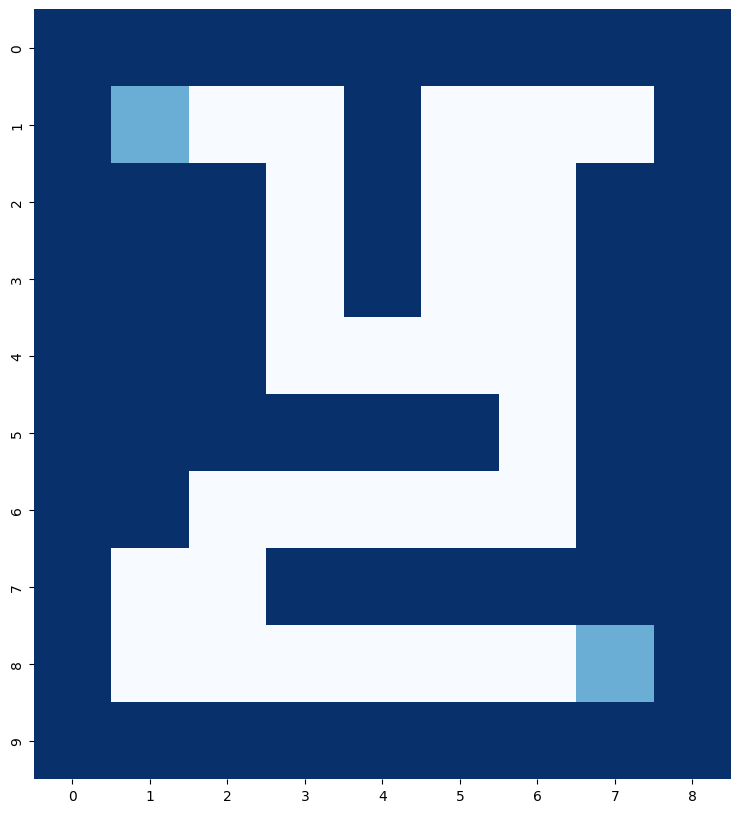

In [212]:
# Define start and goal positions
START = (1,1)
GOAL = (8,7)

# Show the maze using helper functions
showBinaryMazeProblem(maze, START, GOAL)

---
## Extract Graph from the Maze

In order to solve the path-finding problem, we will first extract the *traversal graph* corresponding to the maze. To start with, let's define `MazeGraph`.

In [213]:
# Create a Graph class
class MazeGraph(object):
    ''' Class to represent a Graph
        Construction : Using Edges
    '''
    def __init__(self):
        self.edges = {}
    
    def all_edges(self):
        return self.edges
    
    def neighbors(self, node):
        return self.edges[node]    

### Converting a Maze to a Graph

- The nodes/vertices in the graph are all the blank positions/cells in the maze     
- The blocked positions/cells in the maze are not considered as nodes/vertices
- Each node/vertex is connected to its adjacent blank positions/cells in the maze    
- Each node/vertex is assumed to have 4 adjacent nodes: Top, Left, Bottom, Right     
- Default weight for each such edge in the graph between two adjacent vertices is 1     
- We are assuming that diagonal traversal from one cell to another is not permitted    

In [214]:
# Function to convert a maze to a graph
def maze_to_graph(mazeGrid):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    mazeGraph = MazeGraph()
    (height, width) = mazeGrid.shape
    
    for i in range(height):
        for j in range(width):
            
            # Only consider blank cells as nodes
            if mazeGrid[i,j] == 0:
                
                neighbors = []
                
                # Adjacent cell : Top
                if (i > 0) and mazeGrid[i-1,j] == 0:
                    neighbors.append(((i-1,j), 1))
                    
                # Adjacent cell : Left                
                if (j > 0) and mazeGrid[i,j-1] == 0:
                    neighbors.append(((i,j-1), 1))
                    
                # Adjacent cell : Bottom                    
                if (i < height - 1) and mazeGrid[i+1,j] == 0:
                    neighbors.append(((i+1,j), 1))

                # Adjacent cell : Right                    
                if (j < width - 1) and mazeGrid[i,j+1] == 0:
                    neighbors.append(((i,j+1), 1))

                # Insert edges in the graph
                if len(neighbors) > 0:
                    mazeGraph.edges[(i,j)] = neighbors

    return mazeGraph

In [215]:
# Convert the maze to a graph
mazegraph = maze_to_graph(maze)

# Print the edges with weights
mazegraph.all_edges()

{(1, 1): [((1, 2), 1)],
 (1, 2): [((1, 1), 1), ((1, 3), 1)],
 (1, 3): [((1, 2), 1), ((2, 3), 1)],
 (1, 5): [((2, 5), 1), ((1, 6), 1)],
 (1, 6): [((1, 5), 1), ((2, 6), 1), ((1, 7), 1)],
 (1, 7): [((1, 6), 1)],
 (2, 3): [((1, 3), 1), ((3, 3), 1)],
 (2, 5): [((1, 5), 1), ((3, 5), 1), ((2, 6), 1)],
 (2, 6): [((1, 6), 1), ((2, 5), 1), ((3, 6), 1)],
 (3, 3): [((2, 3), 1), ((4, 3), 1)],
 (3, 5): [((2, 5), 1), ((4, 5), 1), ((3, 6), 1)],
 (3, 6): [((2, 6), 1), ((3, 5), 1), ((4, 6), 1)],
 (4, 3): [((3, 3), 1), ((4, 4), 1)],
 (4, 4): [((4, 3), 1), ((4, 5), 1)],
 (4, 5): [((3, 5), 1), ((4, 4), 1), ((4, 6), 1)],
 (4, 6): [((3, 6), 1), ((4, 5), 1), ((5, 6), 1)],
 (5, 6): [((4, 6), 1), ((6, 6), 1)],
 (6, 2): [((7, 2), 1), ((6, 3), 1)],
 (6, 3): [((6, 2), 1), ((6, 4), 1)],
 (6, 4): [((6, 3), 1), ((6, 5), 1)],
 (6, 5): [((6, 4), 1), ((6, 6), 1)],
 (6, 6): [((5, 6), 1), ((6, 5), 1)],
 (7, 1): [((8, 1), 1), ((7, 2), 1)],
 (7, 2): [((6, 2), 1), ((7, 1), 1), ((8, 2), 1)],
 (8, 1): [((7, 1), 1), ((8, 2), 1)

### Displaying the Maze Graph

**This is optional.** Just a helper function to display the graph using NetworkX. You may examine the graph node-by-node is you wish.

In [216]:
# Helper functions to display a Graph

def showBinaryMazeGraph(mazeGraph):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []
    for node in edgeDict:
        for neighbor, weight in edgeDict[node]:
            edgeList.append((node,neighbor, {'weight': weight}))

    G = nx.Graph()
    G.add_edges_from(edgeList)

    f = plt.figure(figsize = (40,40))
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size = 2000)
    nx.draw_networkx_edges(G, pos, width = 2)
    nx.draw_networkx_labels(G, pos, font_size = 10)

    plt.axis("off")
    plt.show()

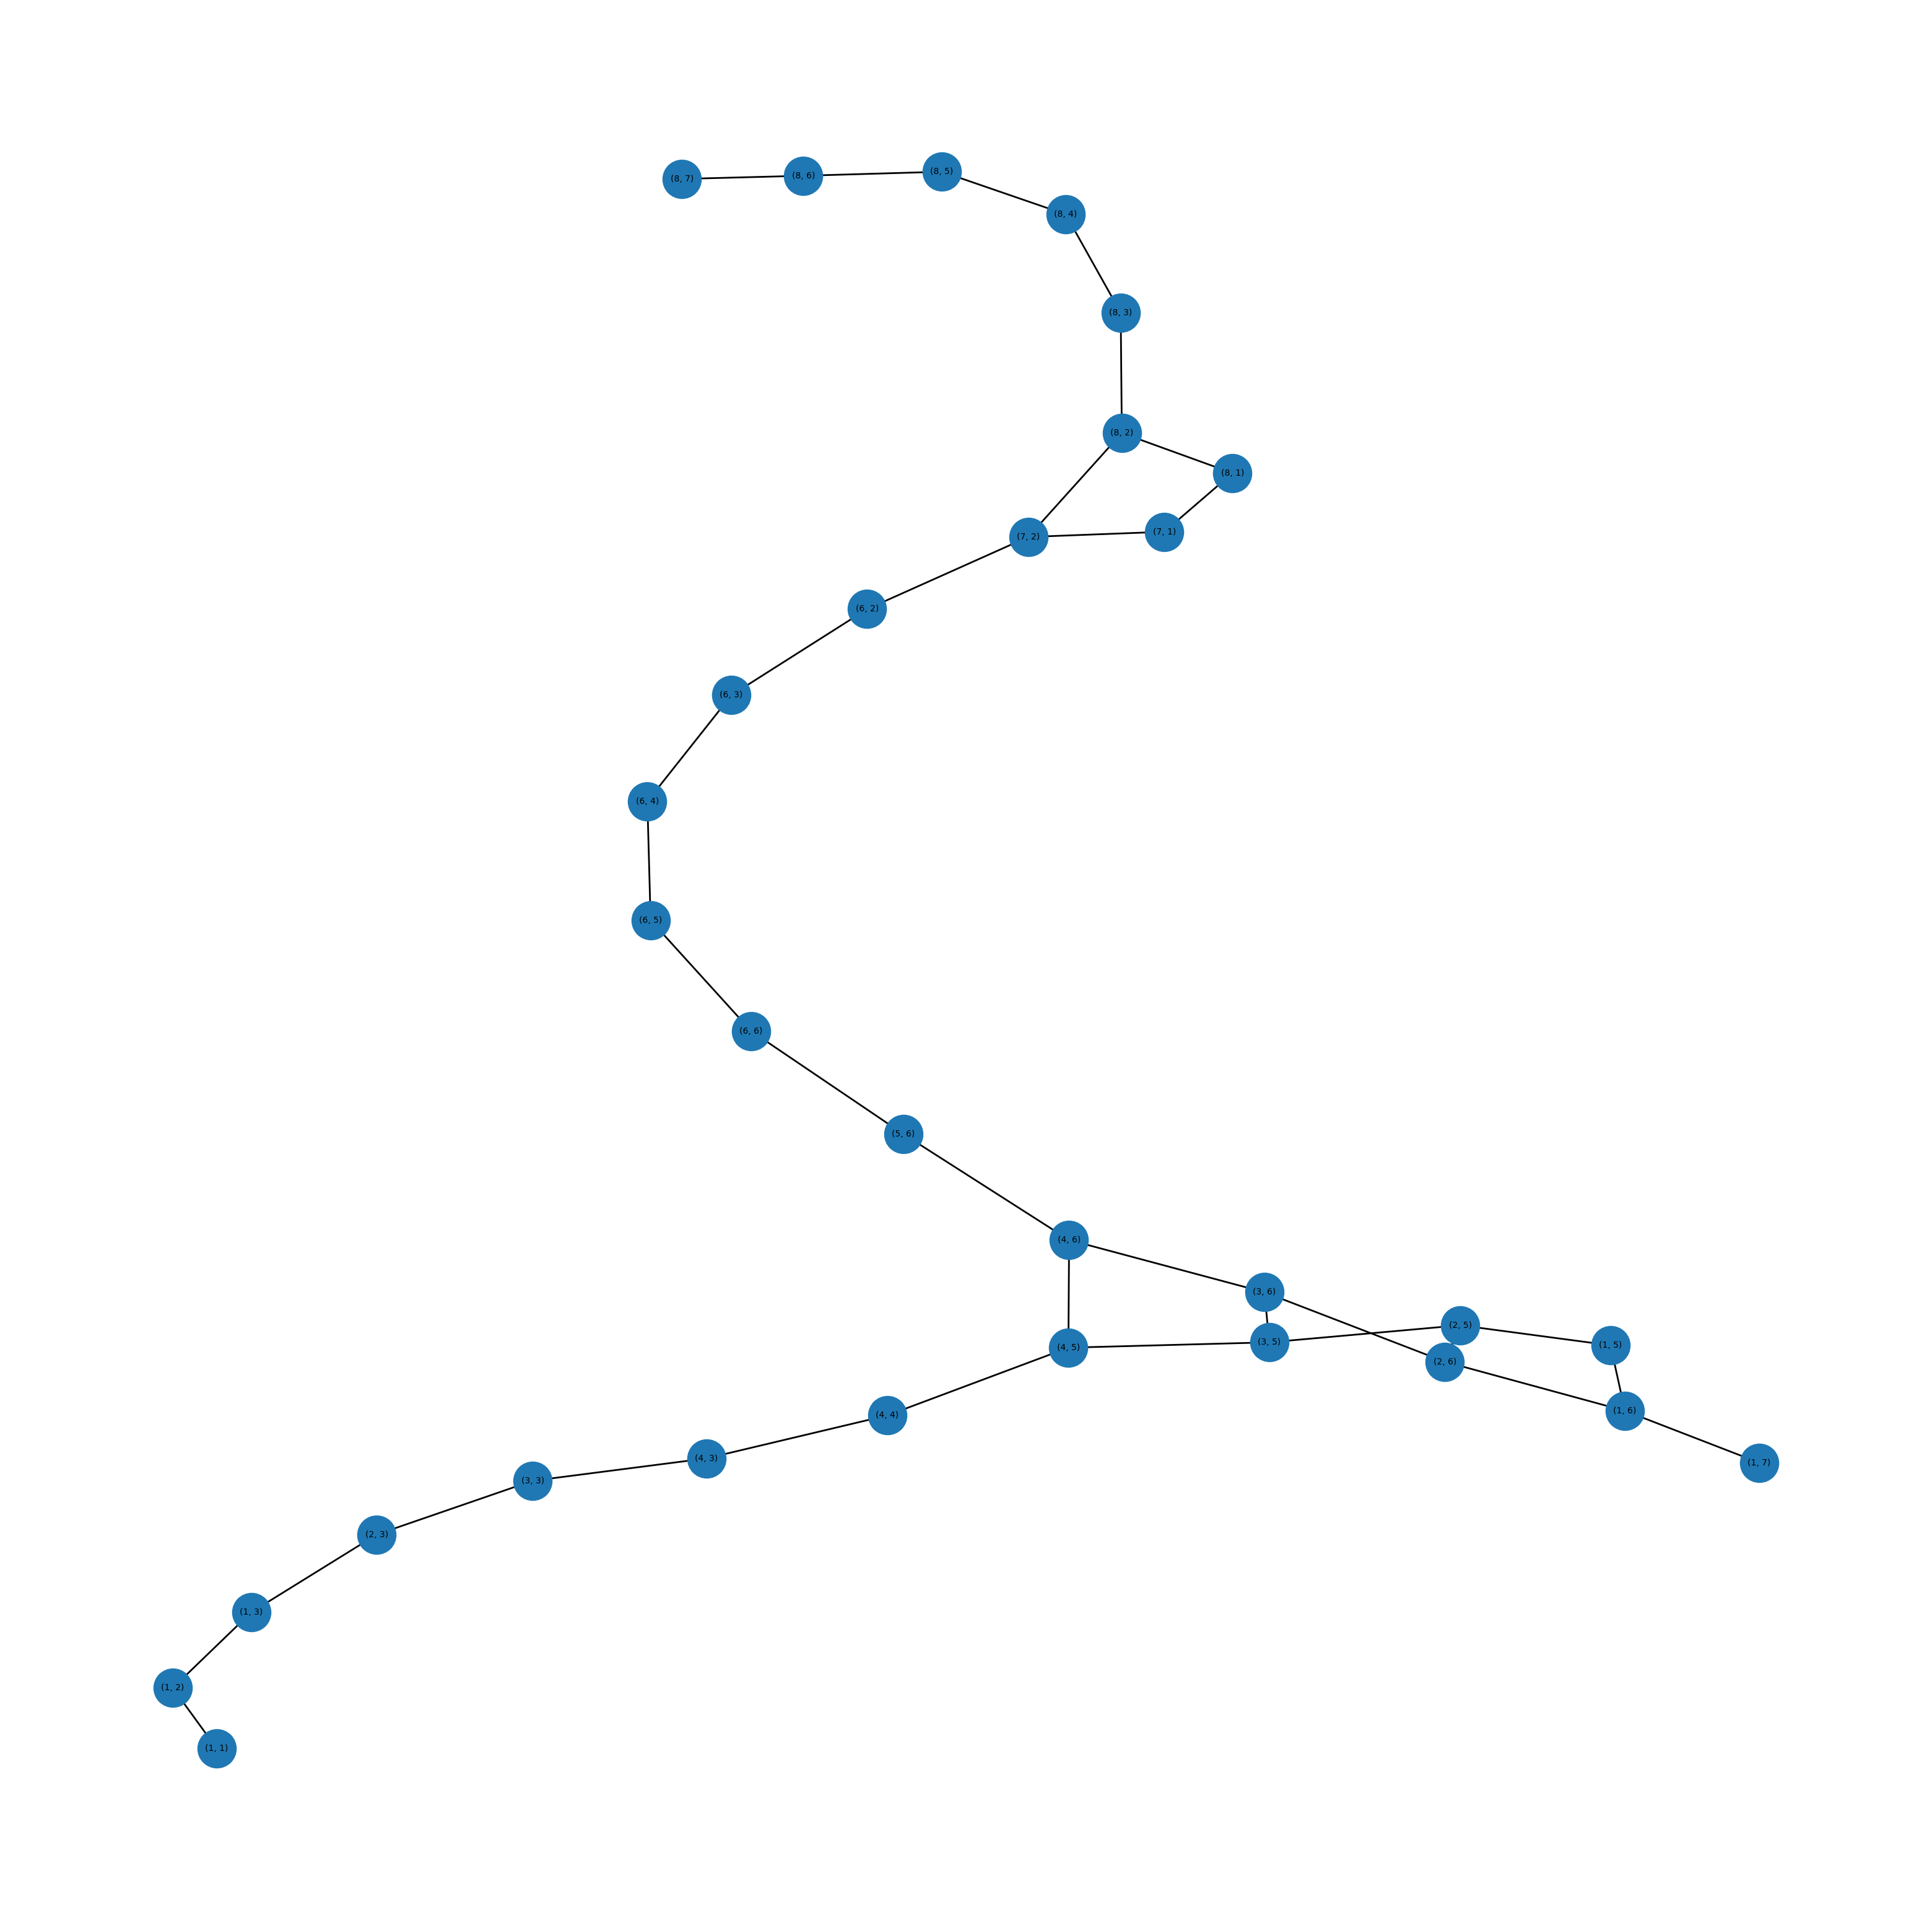

In [217]:
# Show the graph using helper functions
# The layout may change every time you run this cell
# However, the graph (nodes, edges) remains the same
showBinaryMazeGraph(mazegraph)

---
## Path Finding on the Graph

Now that we have the *traversal graph* corresponding to the maze, we may try out various path-finding search algorithms on the graph.

In [218]:
# Helper functions to work with the Maze with Path

def showBinaryMazePath(mazeGrid, mazePath):
    ''' Display the maze corresponding to a binary grid
        Display path(s) superimposed on the binary grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinates of the paths on the maze
        Output : Heatmap grid of the maze with the path
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    for node in mazePath:
        mazeGrid[node[0], node[1]] = 150    # half level of grayscale (0 to 255) to highlight the path
        # for start, end in mazeGrid:
        #     x1, y1 = mazeGrid(node)
        #     x2, y2 = self.position_to_coordinates(end)
        #     color = 'green' if end > start else 'red'
        #     mazePath.plot([x1 + 0.5, x2 + 0.5], [y1 + 0.5, y2 + 0.5], color=color, linewidth=3)
    
    firstNode = mazePath[0]
    lastNode = mazePath[-1]    
    mazeGrid[firstNode[0],firstNode[1]]= 100
    mazeGrid[lastNode[0],lastNode[1]]= 200
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Blues", cbar = False)
    # for node in mazePath:
    #     start = node[0]
    #     end = node[1]
    #     plt.plot(start,end, start+1, end+1 ,color='red',linewidth = 3)
    
    plt.text(firstNode[1]+0.5,firstNode[0]+0.5, "START", color='black', horizontalalignment = 'center', verticalalignment = 'center')
    
    plt.text(lastNode[1]+0.5,lastNode[0]+0.5, "END", color = 'black', horizontalalignment = 'center', verticalalignment = 'center')

    intermediatePath = [((mazePath[i], mazePath[i+1])) for i in range(1, len(mazePath)-2)]
    for line in intermediatePath:
        start = line[0]
        end = line[1]
        y = [start[0]+0.5,end[0]+0.5]
        x = [start[1]+0.5, end[1]+0.5]
        plt.plot(x,y,color = 'red',linewidth = 3.0)
    
    plt.show()

### Breadth-First-Search (BFS)
For the longest path

bfs_longest_path

Total nodes in maze : 31
Total nodes visited : 148  |  477.42 %
Final path distance : 30

Longest Path through the Maze (BFS): [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (7, 2), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


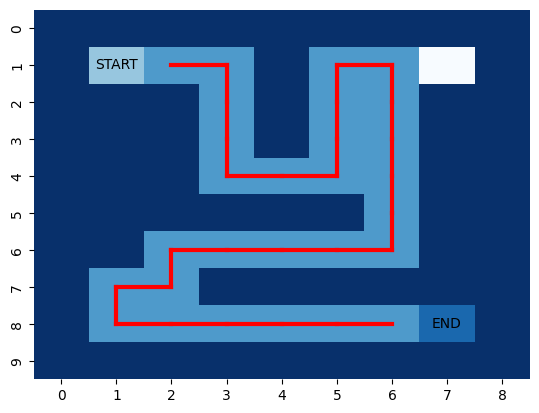

In [219]:
def bfs_longest_path(mazeGraph, start, goal):
    q = queue.Queue()              # Queue for BFS
    q.put((start, [start]))        # Initialize the queue with start node and its path
    longest_path = []              # Store the longest path found
    processed = 0                  # Count of total nodes processed
    
    while not q.empty():
        current_node, path = q.get()
        processed += 1
        
        if current_node == goal:
            if len(path) > len(longest_path):
                longest_path = path
            continue
        
        for next_node, _ in mazeGraph.neighbors(current_node):
            if next_node not in path:
                q.put((next_node, path + [next_node]))
    
    return longest_path, processed

# Run the bfs_longest_path algorithm for path finding
longest_path_bfs, nodesProcessed_bfs = bfs_longest_path(mazegraph, START, GOAL)

# Basic measures for the algorithm
print("bfs_longest_path")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed_bfs, " | ", np.round(100*(nodesProcessed_bfs/totalNodes),2), "%")
print("Final path distance :", len(longest_path_bfs))
print()

# Print the path and show using helper functions
print("Longest Path through the Maze (BFS):", longest_path_bfs)
showBinaryMazePath(maze, longest_path_bfs)


### Depth-First-Search (DFS)
For the longest path

In [220]:
def dfs_longest_path(mazeGraph, start, goal):
    stack = [(start, [start])]    # Stack for DFS (node, path)
    longest_path = []             # Store the longest path found
    processed = 0                 # Count of total nodes processed
    
    while stack:
        current_node, path = stack.pop()
        processed += 1
        
        if current_node == goal:
            if len(path) > len(longest_path):
                longest_path = path
            continue
        
        for next_node, _ in mazeGraph.neighbors(current_node):
            if next_node not in path:
                stack.append((next_node, path + [next_node]))
    
    return longest_path, processed

dfs_longest_path

Total nodes in maze : 31
Total nodes visited : 148  |  477.42 %
Final path distance : 30

Longest Path through the Maze : [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (7, 2), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


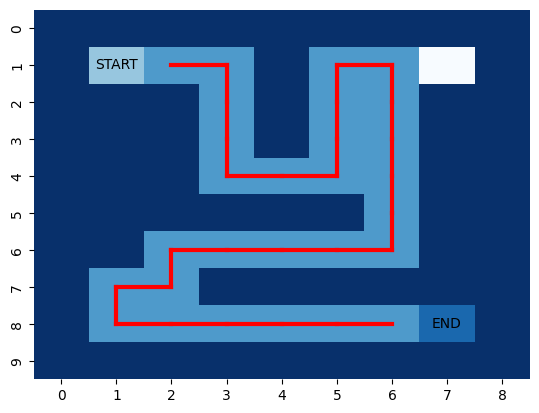

In [221]:
# Define start and goal positions
START = (1,1)
GOAL = (8,7)

# Run the dfs_longest_path algorithm for path finding
longest_path, nodesProcessed = dfs_longest_path(mazegraph, START, GOAL)

# Basic measures for the algorithm
print("dfs_longest_path")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(longest_path))
print()

# Print the path and show using helper functions
print("Longest Path through the Maze :", longest_path)
showBinaryMazePath(maze, longest_path)

### Uniform-Cost-Search (UCS)


uniformed_longest_path

Total nodes in maze : 31
Total nodes visited : 148  |  477.42 %
Final path distance : 30

Longest Path through the Maze (Uniformed Search): [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (7, 2), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


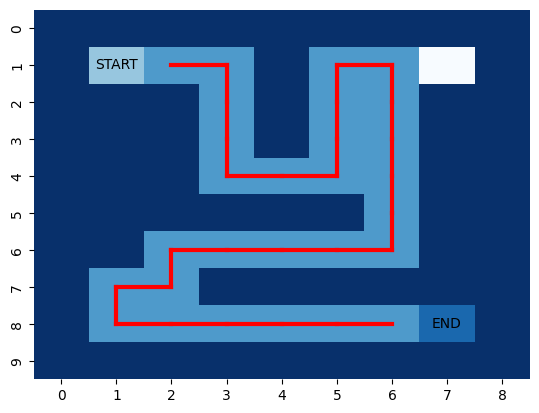

In [222]:
def uniformed_longest_path(mazeGraph, start, goal):
    pq = queue.PriorityQueue()     # Priority Queue for Uniformed Search
    pq.put((0, start, [start]))    # Initialize the priority queue with start node and its path
    longest_path = []              # Store the longest path found
    processed = 0                  # Count of total nodes processed
    
    while not pq.empty():
        _, current_node, path = pq.get()
        processed += 1
        
        if current_node == goal:
            if len(path) > len(longest_path):
                longest_path = path
            continue
        
        for next_node, _ in mazeGraph.neighbors(current_node):
            if next_node not in path:
                priority = -len(path)  # Priority is negative length of path (longer paths have higher priority)
                pq.put((priority, next_node, path + [next_node]))
    
    return longest_path, processed

# Run the uniformed_longest_path algorithm for path finding
longest_path_uniformed, nodesProcessed_uniformed = uniformed_longest_path(mazegraph, START, GOAL)

# Basic measures for the algorithm
print("uniformed_longest_path")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed_uniformed, " | ", np.round(100*(nodesProcessed_uniformed/totalNodes),2), "%")
print("Final path distance :", len(longest_path_uniformed))
print()

# Print the path and show using helper functions
print("Longest Path through the Maze (Uniformed Search):", longest_path_uniformed)
showBinaryMazePath(maze, longest_path_uniformed)


### Greedy-Search (GS)

greedy_longest_path

Total nodes in maze : 31
Total nodes visited : 148  |  477.42 %
Final path distance : 30

Longest Path through the Maze (Greedy Search): [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (7, 2), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


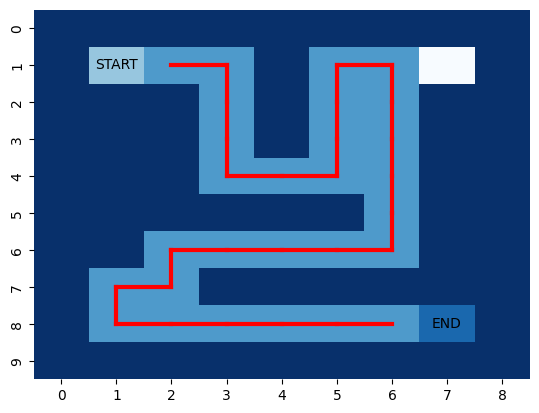

In [223]:
def greedy_longest_path(mazeGraph, start, goal):
    pq = queue.PriorityQueue()     # Priority Queue for Greedy Search
    pq.put((0, start, [start]))    # Initialize the priority queue with start node and its path
    longest_path = []              # Store the longest path found
    processed = 0                  # Count of total nodes processed
    
    while not pq.empty():
        _, current_node, path = pq.get()
        processed += 1
        
        if current_node == goal:
            if len(path) > len(longest_path):
                longest_path = path
            continue
        
        for next_node, _ in mazeGraph.neighbors(current_node):
            if next_node not in path:
                # Calculate the priority based on the distance to the goal
                priority = -manhattan_distance(next_node, goal)  # Negative distance to prioritize longer paths
                pq.put((priority, next_node, path + [next_node]))
    
    return longest_path, processed

def manhattan_distance(node1, node2):
    # Manhattan distance heuristic
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

# Run the greedy_longest_path algorithm for path finding
longest_path_greedy, nodesProcessed_greedy = greedy_longest_path(mazegraph, START, GOAL)

# Basic measures for the algorithm
print("greedy_longest_path")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed_greedy, " | ", np.round(100*(nodesProcessed_greedy/totalNodes),2), "%")
print("Final path distance :", len(longest_path_greedy))
print()

# Print the path and show using helper functions
print("Longest Path through the Maze (Greedy Search):", longest_path_greedy)
showBinaryMazePath(maze, longest_path_greedy)

### A* search (A*S)

astar_longest_path

Total nodes in maze : 31
Total nodes visited : 148  |  477.42 %
Final path distance : 30

Longest Path through the Maze (A* Search): [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5), (2, 5), (1, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (7, 2), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


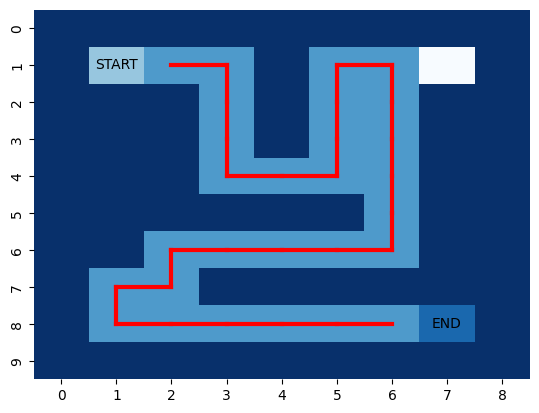

In [224]:
import queue

def astar_longest_path(mazeGraph, start, goal):
    pq = queue.PriorityQueue()     # Priority Queue for A* Search
    pq.put((0, start, [start]))    # Initialize the priority queue with start node and its path
    longest_path = []              # Store the longest path found
    processed = 0                  # Count of total nodes processed
    
    while not pq.empty():
        _, current_node, path = pq.get()
        processed += 1
        
        if current_node == goal:
            if len(path) > len(longest_path):
                longest_path = path
            continue
        
        for next_node, _ in mazeGraph.neighbors(current_node):
            if next_node not in path:
                # Calculate the priority based on the total cost (actual cost + heuristic)
                priority = -(len(path) + manhattan_distance(next_node, goal))
                pq.put((priority, next_node, path + [next_node]))
    
    return longest_path, processed

def manhattan_distance(node1, node2):
    # Manhattan distance heuristic
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

# Run the astar_longest_path algorithm for path finding
longest_path_astar, nodesProcessed_astar = astar_longest_path(mazegraph, START, GOAL)

# Basic measures for the algorithm
print("astar_longest_path")
print()

totalNodes = np.count_nonzero(maze == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed_astar, " | ", np.round(100*(nodesProcessed_astar/totalNodes),2), "%")
print("Final path distance :", len(longest_path_astar))
print()

# Print the path and show using helper functions
print("Longest Path through the Maze (A* Search):", longest_path_astar)
showBinaryMazePath(maze, longest_path_astar)


## Iterative Deepening Search


As our game requires the player to find the longest blocks that lead to the end goal, we would not be implementing this search as it searches for the shortest path in a maze.

## Bidirectional Search


We will not be implementing this search as well as our game does not allow for the user to backtrack.

## Explanation and elaboration of search algorithm:

